* train : 2103 장 / validation(test) : 1111 장

* learning rate : 1e-3
* epoch = 50
* param : set 1
* optimizer : Adam
* scheduler : None
* result : {Avg Loss: 70.1300, Avg PSNR: 29.8700, Avg SSIM: 0.9269}, {Val Loss: 71.0571, Val PSNR: 28.9429, Val SSIM: 0.9219}

In [1]:
%%capture
!pip install torchsummary

In [2]:
import os
import torch
import numpy as np
import random

from PIL import Image
from torch import nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchmetrics.image import StructuralSimilarityIndexMeasure
from glob import glob
import gc

root_path = glob('../../*/input/', recursive = True)
data_path = glob(f'{root_path[0]}/*/DBlur', recursive = True)[0]

dataset_path = os.path.join(data_path, 'Gopro')

class Configs:
    size = 256
    batch_size = 16
    num_workers = 4

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    mode = ['train','valid', 'test']
    epoch = 50
    lr = 1e-3

class Transform:
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    
    transforms = transforms.Compose([
        transforms.Resize((Configs.size, Configs.size), Image.BICUBIC),
        transforms.RandomHorizontalFlip(0.2),
        transforms.RandomVerticalFlip(0.2),
        transforms.ToTensor(),
        #transforms.Normalize(mean, std), #Normalize 적용 시 PSNR, SSIM 모두 떨어짐
    ])

## Dataset Pre-processing

In [3]:
class ImageDataset(Dataset):
    
    def __init__(self, dataset_path, mode, transforms):
        self.mode = mode
        self.dataset_path = dataset_path
        
        self.data_path = os.path.join(self.dataset_path, self.mode)
        self.transforms = transforms

    def __getitem__(self, index):

        seed = np.random.randint(2147483647) #transforms random seed fix
    
        noise_image = Image.open(glob(os.path.join(self.data_path, 'blur') + '/*.png')[index]).convert('RGB')
        clean_image = Image.open(glob(os.path.join(self.data_path, 'sharp') + '/*.png')[index]).convert('RGB')

        if self.transforms is not None:
            torch.manual_seed(seed)
            noise_image = self.transforms(noise_image)
            
            torch.manual_seed(seed)
            clean_image = self.transforms(clean_image)
        
        return noise_image, clean_image

    def __len__(self):
        return len(glob(os.path.join(self.data_path , 'blur') + '/*.png'))
    

In [4]:
train_dataset = ImageDataset(dataset_path = dataset_path, mode = Configs.mode[0], transforms = Transform.transforms)
test_dataset = ImageDataset(dataset_path = dataset_path, mode = Configs.mode[2], transforms = Transform.transforms)

train_dataloader = DataLoader(train_dataset, batch_size = Configs.batch_size, shuffle = True, num_workers = Configs.num_workers)
test_dataloader = DataLoader(test_dataset, batch_size = Configs.batch_size, shuffle = True, num_workers = Configs.num_workers)   

## Dataset Check

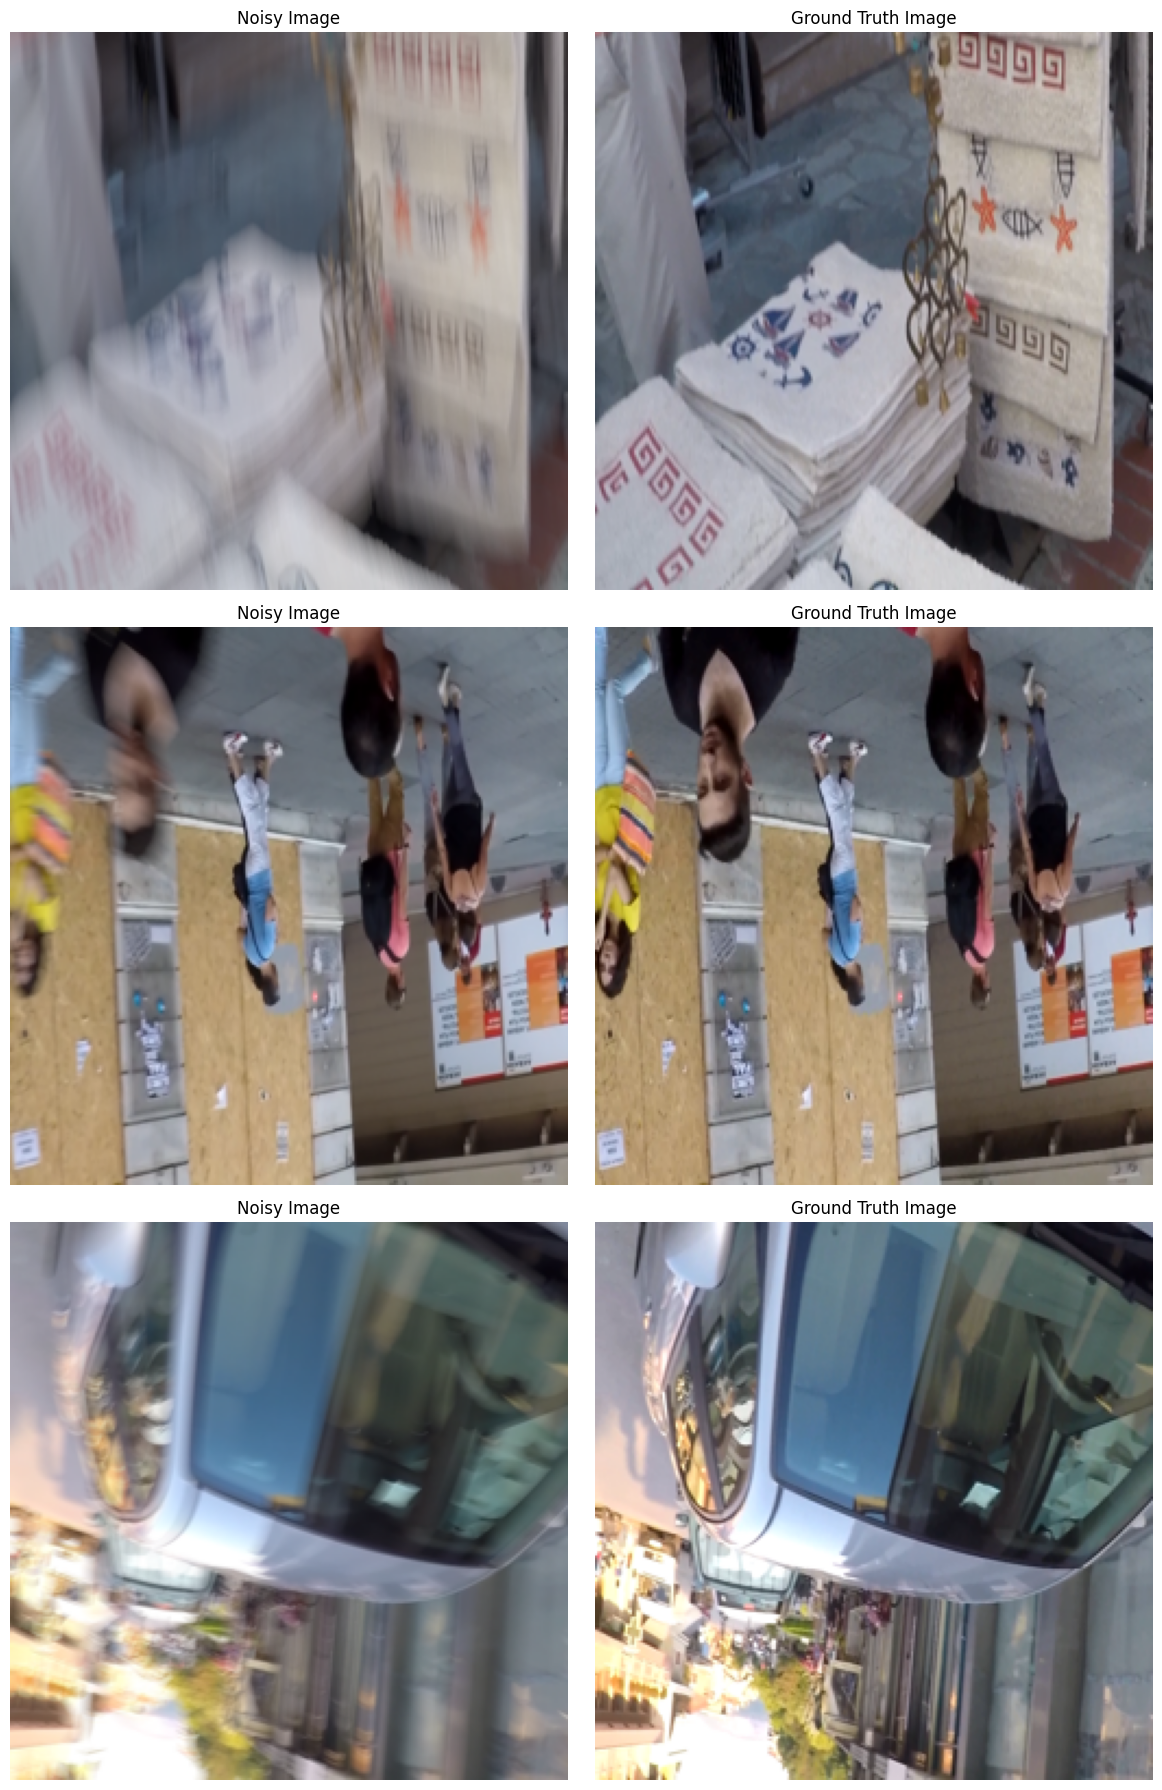

In [5]:
from matplotlib import pyplot as plt

num_images_to_display = 3
plt.figure(figsize=(12, 6*num_images_to_display))

dataset_path = os.path.join(data_path, 'Gopro')
train_data_path = os.path.join(dataset_path, 'train')

# Permute axis for each image pair before displaying
for i in range(num_images_to_display):
    # Permute axis for noisy image
    seed = np.random.randint(2147483647) 
    
    noise_image = Image.open(glob(os.path.join(train_data_path, 'blur') + '/*.png')[i]).convert('RGB')
    clean_image = Image.open(glob(os.path.join(train_data_path, 'sharp') + '/*.png')[i]).convert('RGB')
    
    torch.manual_seed(seed)
    noise_image = Transform.transforms(noise_image)
    torch.manual_seed(seed)
    clean_image = Transform.transforms(clean_image)
    
    # Plot noisy image
    plt.subplot(num_images_to_display, 2, i*2 + 1)
    plt.imshow(noise_image.permute(1, 2, 0))
    plt.title("Noisy Image")
    plt.axis('off')
    
    # Plot ground truth image
    plt.subplot(num_images_to_display, 2, i*2 + 2)
    plt.imshow(clean_image.permute(1, 2, 0))
    plt.title("Ground Truth Image")
    plt.axis('off')

plt.tight_layout()
plt.show()

## NAFNet Architecture Preparation
1. LayerNormFunction
2. NAFNet Intra-Block Architecture
3. NAFNet Inter-Block Architecture

#### 1. LayerNormFunction

In [6]:
class LayerNormFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, weight, bias, eps):
        ctx.eps = eps
        N, C, H, W = x.size()
        mu = x.mean(1, keepdim=True)
        var = (x - mu).pow(2).mean(1, keepdim=True)
        y = (x - mu) / (var + eps).sqrt()
        ctx.save_for_backward(y, var, weight)
        y = weight.view(1, C, 1, 1) * y + bias.view(1, C, 1, 1)
        return y

    @staticmethod
    def backward(ctx, grad_output):
        eps = ctx.eps

        N, C, H, W = grad_output.size()
        y, var, weight = ctx.saved_variables
        g = grad_output * weight.view(1, C, 1, 1)
        mean_g = g.mean(dim=1, keepdim=True)

        mean_gy = (g * y).mean(dim=1, keepdim=True)
        gx = 1. / torch.sqrt(var + eps) * (g - y * mean_gy - mean_g)
        return gx, (grad_output * y).sum(dim=3).sum(dim=2).sum(dim=0), grad_output.sum(dim=3).sum(dim=2).sum(
            dim=0), None

class LayerNorm2d(nn.Module):

    def __init__(self, channels, eps=1e-6):
        super(LayerNorm2d, self).__init__()
        self.register_parameter('weight', nn.Parameter(torch.ones(channels)))
        self.register_parameter('bias', nn.Parameter(torch.zeros(channels)))
        self.eps = eps

    def forward(self, x):
        return LayerNormFunction.apply(x, self.weight, self.bias, self.eps)

#### 2. NAFNet Intra-Block Architecture

In [7]:
class Local_Base():
    def convert(self, *args, train_size, **kwargs):
        replace_layers(self, *args, train_size=train_size, **kwargs)
        imgs = torch.rand(train_size)
        with torch.no_grad():
            self.forward(imgs)

class SimpleGate(nn.Module):
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=1)
        return x1 * x2

class NAFBlock(nn.Module):
    def __init__(self, c, DW_Expand=2, FFN_Expand=2, drop_out_rate=0.):
        super().__init__()
        dw_channel = c * DW_Expand
        self.conv1 = nn.Conv2d(in_channels=c, out_channels=dw_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=dw_channel, out_channels=dw_channel, kernel_size=3, padding=1, stride=1, groups=dw_channel,
                               bias=True)
        self.conv3 = nn.Conv2d(in_channels=dw_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        
        # Simplified Channel Attention
        self.sca = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels=dw_channel // 2, out_channels=dw_channel // 2, kernel_size=1, padding=0, stride=1,
                      groups=1, bias=True),
        )

        # SimpleGate
        self.sg = SimpleGate()

        ffn_channel = FFN_Expand * c
        self.conv4 = nn.Conv2d(in_channels=c, out_channels=ffn_channel, kernel_size=1, padding=0, stride=1, groups=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=ffn_channel // 2, out_channels=c, kernel_size=1, padding=0, stride=1, groups=1, bias=True)

        self.norm1 = LayerNorm2d(c)
        self.norm2 = LayerNorm2d(c)

        self.dropout1 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()
        self.dropout2 = nn.Dropout(drop_out_rate) if drop_out_rate > 0. else nn.Identity()

        self.beta = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)
        self.gamma = nn.Parameter(torch.zeros((1, c, 1, 1)), requires_grad=True)

    def forward(self, inp):
        x = inp

        x = self.norm1(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.sg(x)
        x = x * self.sca(x)
        x = self.conv3(x)

        x = self.dropout1(x)

        y = inp + x * self.beta

        x = self.conv4(self.norm2(y))
        x = self.sg(x)
        x = self.conv5(x)

        x = self.dropout2(x)

        return y + x * self.gamma

#### 3. NAFNet Inter-Block Architecture

In [8]:
class NAFNet(nn.Module):

    def __init__(self, img_channel=3, width=16, middle_blk_num=1, enc_blk_nums=[], dec_blk_nums=[]):
        super().__init__()

        self.intro = nn.Conv2d(in_channels=img_channel, out_channels=width, kernel_size=3, padding=1, stride=1, groups=1,
                              bias=True)
        self.ending = nn.Conv2d(in_channels=width, out_channels=img_channel, kernel_size=3, padding=1, stride=1, groups=1,
                              bias=True)

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.middle_blks = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()

        chan = width
        for num in enc_blk_nums:
            self.encoders.append(
                nn.Sequential(
                    *[NAFBlock(chan) for _ in range(num)]
                )
            )
            self.downs.append(
                nn.Conv2d(chan, 2*chan, 2, 2)
            )
            chan = chan * 2

        self.middle_blks = \
            nn.Sequential(
                *[NAFBlock(chan) for _ in range(middle_blk_num)]
            )

        for num in dec_blk_nums:
            self.ups.append(
                nn.Sequential(
                    nn.Conv2d(chan, chan * 2, 1, bias=False),
                    nn.PixelShuffle(2)
                )
            )
            chan = chan // 2
            self.decoders.append(
                nn.Sequential(
                    *[NAFBlock(chan) for _ in range(num)]
                )
            )

        self.padder_size = 2 ** len(self.encoders)

    def forward(self, inp):
        B, C, H, W = inp.shape
        inp = self.check_image_size(inp)

        x = self.intro(inp)

        encs = []

        for encoder, down in zip(self.encoders, self.downs):
            x = encoder(x)
            encs.append(x)
            x = down(x)

        x = self.middle_blks(x)

        for decoder, up, enc_skip in zip(self.decoders, self.ups, encs[::-1]):
            x = up(x)
            x = x + enc_skip
            x = decoder(x)

        x = self.ending(x)
        x = x + inp

        return x[:, :, :H, :W]

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.padder_size - h % self.padder_size) % self.padder_size
        mod_pad_w = (self.padder_size - w % self.padder_size) % self.padder_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h))
        return x

## Param Change

In [ ]:
img_channel = 3

width = 32

#default Nafnet set
#enc_blks = [1, 1, 1, 28]
#middle_blk_num = 1
#dec_blks = [1, 1, 1, 1]

#set 1
enc_blks = [1, 1, 1, 1]
middle_blk_num = 1
dec_blks = [1, 1, 1, 1]

#set 2
# enc_blks = [2, 2, 4, 8]
# middle_blk_num = 12
# dec_blks = [2, 2, 2, 2]

## Model Define & Param check

In [ ]:
model = NAFNet(img_channel=img_channel, width=width, middle_blk_num=middle_blk_num,
               enc_blk_nums=enc_blks, dec_blk_nums=dec_blks).to(Configs.device)

inp_shape = (3, 256, 256)

def get_model_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params


# Calculate and print model parameters
total_params, trainable_params = get_model_params(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 4497507
Trainable parameters: 4497507


In [11]:
from torchsummary import summary
result = summary(model, (3, 256 ,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       LayerNorm2d-2         [-1, 32, 256, 256]              64
            Conv2d-3         [-1, 64, 256, 256]           2,112
            Conv2d-4         [-1, 64, 256, 256]             640
        SimpleGate-5         [-1, 32, 256, 256]               0
 AdaptiveAvgPool2d-6             [-1, 32, 1, 1]               0
            Conv2d-7             [-1, 32, 1, 1]           1,056
            Conv2d-8         [-1, 32, 256, 256]           1,056
          Identity-9         [-1, 32, 256, 256]               0
      LayerNorm2d-10         [-1, 32, 256, 256]              64
           Conv2d-11         [-1, 64, 256, 256]           2,112
       SimpleGate-12         [-1, 32, 256, 256]               0
           Conv2d-13         [-1, 32, 256, 256]           1,056
         Identity-14         [-1, 32, 2

## Loss function with PSNR, SSIM

In [12]:
class loss_Calc():
    def __init__(self,output_img, sharp_img, device):
        self.output_img = output_img
        self.sharp_img = sharp_img
        self.device = device
        self.data_range = 1.0
    
    def ssim_calc(self):
        ssim = StructuralSimilarityIndexMeasure(self.data_range).to(self.device)
        return ssim(self.output_img, self.sharp_img)
    
    def mse_calc(self):
        mse = F.mse_loss(self.output_img, self.sharp_img)
        return mse

    def psnr_calc(self):
        psnr = 20*torch.log10(self.data_range / torch.sqrt(self.mse_calc()))
        return psnr
        
    def loss_func(self):
        loss_val = 100-self.psnr_calc() #PSNR값은 올라가고 loss값은 내려가야 되기 때문?
        return loss_val

    def metrics(self):
        return self.ssim_calc(), self.mse_calc(), self.psnr_calc(), self.loss_func()

## Train & Evaluation

In [ ]:
class Trainer():
    def __init__(self, model, batch_size, epoch, lr, device, mode, T_max = 100):
        self.model = model
        self.batch_size = batch_size
        self.epoch = epoch
        self.lr = lr
        self.device = device
        self.mode = mode
        self.T_max = T_max
        self.opt = torch.optim.Adam(self.model.parameters(), lr = self.lr)
        self.sch = torch.optim.lr_scheduler.StepLR(optimizer = self.opt, step_size=10, gamma=0.1)
        #self.sch = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer = self.opt, T_max = self.T_max, eta_min = 0)
        self.history = {'train_loss' : [],
                        'valid_loss' : [],
                        'train_psnr' : [],
                        'valid_psnr' : [],
                        'train_ssim' : [],
                        'valid_ssim' : []}

    def history_update(self, mode, metric_dict):
        for k, v in self.history.items():
            if mode in k:
                metric_type = k.split('_')[-1]
        
                for x, y in metric_dict.items():
                    if metric_type in x:
                        self.history[k].append(y)
                
    def total_metric(self, loss, psnr, ssim):
        self.total_ssim += ssim.item()
        self.total_psnr += psnr.item()
        self.total_loss += loss.item()


    def avg_metric(self, len, mode):
        avg_loss = self.total_loss / len
        avg_psnr = self.total_psnr / len
        avg_ssim = self.total_ssim / len

        if mode == 'train':
            print(f"\nAvg Loss: {avg_loss:.4f}, Avg PSNR: {avg_psnr:.4f}, Avg SSIM: {avg_ssim:.4f}")
            
        elif mode == 'valid':
            print(f"Val Loss: {avg_loss:.4f}, Val PSNR: {avg_psnr:.4f}, Val SSIM: {avg_ssim:.4f}")

        return {'avg_loss' : avg_loss , 'avg_psnr' : avg_psnr, 'avg_ssim' : avg_ssim}

    def train(self, dataloader, mode, cur_epoch):
        self.total_loss, self.total_psnr, self.total_ssim = 0,0,0
        self.model.train()
        progress_bar = tqdm(dataloader)
        
        for batch_idx, (noise, clean) in enumerate(progress_bar):
            gc.collect()

            self.opt.zero_grad()

            inputs, labels = noise.to(self.device), clean.to(self.device)
            outputs = self.model(inputs)

            # Evaluate with various Metric Index
            ssim, mse, psnr, loss = loss_Calc(output_img = outputs, sharp_img = labels, device = self.device).metrics()

            # Total Metric Values Compusing
            self.total_metric(loss, psnr, ssim)
            loss.backward()
            self.opt.step()

            progress_bar.set_description(f'Step {cur_epoch} [{batch_idx+1}/{len(dataloader)}]')
            progress_bar.set_postfix(loss = loss.item(), psnr = psnr.item(), ssim = ssim.item())

        # Average Metric Values Compusing
        metric_dict = self.avg_metric(len = len(dataloader), mode = mode)

        # For Visualization of Loss & Various Metrics with Graph
        self.history_update(mode, metric_dict)

    def evaluate(self, dataloader, mode):
        # Construct dataloader comparing function for applying k-folds system with valid_dataloader
        
        self.total_loss, self.total_psnr, self.total_ssim = 0,0,0
        self.model.eval()
        
        with torch.no_grad():
            for noise, clean in dataloader:
                gc.collect()

                inputs, labels = noise.to(self.device), clean.to(self.device)
                outputs = self.model(inputs)

                ssim, mse, psnr, loss = loss_Calc(output_img = outputs, sharp_img = labels, device = self.device).metrics()

                self.total_metric(loss, psnr, ssim)

            metric_dict = self.avg_metric(len = len(dataloader), mode = mode)
            self.history_update(mode, metric_dict)
        
    def fit(self,train_dataloader, test_dataloader):
        self.model.to(self.device)
        for i in range(self.epoch):
            self.train(train_dataloader, self.mode[0], cur_epoch = i + 1)
            self.evaluate(test_dataloader,self.mode[1])
            #self.sch.step()

        

In [14]:
trainer = Trainer(model = model, batch_size = Configs.batch_size, epoch = Configs.epoch, lr = Configs.lr, device = Configs.device, mode = Configs.mode)

model_fit = trainer.fit(train_dataloader, test_dataloader)

  0%|          | 0/132 [00:00<?, ?it/s]/tmp/ipykernel_23/698487685.py:19: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  y, var, weight = ctx.saved_variables
Step 1 [132/132]: 100%|██████████| 132/132 [01:57<00:00,  1.12it/s, loss=74.1, psnr=25.9, ssim=0.853]


Avg Loss: 74.4073, Avg PSNR: 25.5927, Avg SSIM: 0.8401


Val Loss: 73.6223, Val PSNR: 26.3777, Val SSIM: 0.8663


Step 2 [132/132]: 100%|██████████| 132/132 [02:00<00:00,  1.09it/s, loss=76.3, psnr=23.7, ssim=0.761]


Avg Loss: 73.8499, Avg PSNR: 26.1501, Avg SSIM: 0.8532


Val Loss: 73.3648, Val PSNR: 26.6352, Val SSIM: 0.8714


Step 3 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=73.6, psnr=26.4, ssim=0.848]


Avg Loss: 73.5554, Avg PSNR: 26.4446, Avg SSIM: 0.8597


Val Loss: 73.1050, Val PSNR: 26.8950, Val SSIM: 0.8752


Step 4 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=71.6, psnr=28.4, ssim=0.907]


Avg Loss: 73.3146, Avg PSNR: 26.6854, Avg SSIM: 0.8662


Val Loss: 73.0138, Val PSNR: 26.9862, Val SSIM: 0.8804


Step 5 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=73.8, psnr=26.2, ssim=0.866]


Avg Loss: 73.1285, Avg PSNR: 26.8715, Avg SSIM: 0.8716


Val Loss: 72.8996, Val PSNR: 27.1004, Val SSIM: 0.8815


Step 6 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=70.9, psnr=29.1, ssim=0.913]


Avg Loss: 72.9942, Avg PSNR: 27.0058, Avg SSIM: 0.8754


Val Loss: 72.7440, Val PSNR: 27.2560, Val SSIM: 0.8846


Step 7 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=72, psnr=28, ssim=0.917]


Avg Loss: 72.8471, Avg PSNR: 27.1529, Avg SSIM: 0.8794


Val Loss: 72.6598, Val PSNR: 27.3402, Val SSIM: 0.8882


Step 8 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=69.3, psnr=30.7, ssim=0.943]


Avg Loss: 72.6971, Avg PSNR: 27.3029, Avg SSIM: 0.8828


Val Loss: 72.6399, Val PSNR: 27.3601, Val SSIM: 0.8866


Step 9 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.08it/s, loss=69.3, psnr=30.7, ssim=0.943]


Avg Loss: 72.6194, Avg PSNR: 27.3806, Avg SSIM: 0.8846


Val Loss: 72.6298, Val PSNR: 27.3702, Val SSIM: 0.8886


Step 10 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=73.2, psnr=26.8, ssim=0.856]


Avg Loss: 72.5543, Avg PSNR: 27.4457, Avg SSIM: 0.8859


Val Loss: 72.4829, Val PSNR: 27.5171, Val SSIM: 0.8945


Step 11 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=69.5, psnr=30.5, ssim=0.929]


Avg Loss: 72.4575, Avg PSNR: 27.5425, Avg SSIM: 0.8879


Val Loss: 72.3802, Val PSNR: 27.6198, Val SSIM: 0.8943


Step 12 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.08it/s, loss=73, psnr=27, ssim=0.856]


Avg Loss: 72.3506, Avg PSNR: 27.6494, Avg SSIM: 0.8901


Val Loss: 72.2960, Val PSNR: 27.7040, Val SSIM: 0.8971


Step 13 [132/132]: 100%|██████████| 132/132 [02:02<00:00,  1.08it/s, loss=73.7, psnr=26.3, ssim=0.847]


Avg Loss: 72.2671, Avg PSNR: 27.7329, Avg SSIM: 0.8919


Val Loss: 72.2806, Val PSNR: 27.7194, Val SSIM: 0.8970


Step 14 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=73.6, psnr=26.4, ssim=0.87]


Avg Loss: 72.1529, Avg PSNR: 27.8471, Avg SSIM: 0.8937


Val Loss: 72.2603, Val PSNR: 27.7397, Val SSIM: 0.8985


Step 15 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=72.4, psnr=27.6, ssim=0.891]


Avg Loss: 72.0740, Avg PSNR: 27.9260, Avg SSIM: 0.8955


Val Loss: 72.2057, Val PSNR: 27.7943, Val SSIM: 0.8995


Step 16 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=70, psnr=30, ssim=0.935]


Avg Loss: 72.0049, Avg PSNR: 27.9951, Avg SSIM: 0.8968


Val Loss: 72.1169, Val PSNR: 27.8831, Val SSIM: 0.8986


Step 17 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=73, psnr=27, ssim=0.885]


Avg Loss: 71.9456, Avg PSNR: 28.0544, Avg SSIM: 0.8979


Val Loss: 72.1225, Val PSNR: 27.8775, Val SSIM: 0.9008


Step 18 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=71.4, psnr=28.6, ssim=0.904]


Avg Loss: 71.9192, Avg PSNR: 28.0808, Avg SSIM: 0.8987


Val Loss: 72.0592, Val PSNR: 27.9408, Val SSIM: 0.9002


Step 19 [132/132]: 100%|██████████| 132/132 [02:02<00:00,  1.08it/s, loss=69.6, psnr=30.4, ssim=0.927]


Avg Loss: 71.7410, Avg PSNR: 28.2590, Avg SSIM: 0.9013


Val Loss: 71.9614, Val PSNR: 28.0386, Val SSIM: 0.9038


Step 20 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.08it/s, loss=67.8, psnr=32.2, ssim=0.956]


Avg Loss: 71.6208, Avg PSNR: 28.3792, Avg SSIM: 0.9038


Val Loss: 72.0441, Val PSNR: 27.9559, Val SSIM: 0.9007


Step 21 [132/132]: 100%|██████████| 132/132 [02:02<00:00,  1.08it/s, loss=72.3, psnr=27.7, ssim=0.894]


Avg Loss: 71.6018, Avg PSNR: 28.3982, Avg SSIM: 0.9042


Val Loss: 71.8430, Val PSNR: 28.1570, Val SSIM: 0.9040


Step 22 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=72.5, psnr=27.5, ssim=0.901]


Avg Loss: 71.5772, Avg PSNR: 28.4228, Avg SSIM: 0.9050


Val Loss: 71.7784, Val PSNR: 28.2216, Val SSIM: 0.9076


Step 23 [132/132]: 100%|██████████| 132/132 [02:02<00:00,  1.08it/s, loss=73.6, psnr=26.4, ssim=0.849]


Avg Loss: 71.4750, Avg PSNR: 28.5250, Avg SSIM: 0.9062


Val Loss: 71.8759, Val PSNR: 28.1241, Val SSIM: 0.9067


Step 24 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=72.3, psnr=27.7, ssim=0.87]


Avg Loss: 71.4625, Avg PSNR: 28.5375, Avg SSIM: 0.9059


Val Loss: 71.8299, Val PSNR: 28.1701, Val SSIM: 0.9063


Step 25 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=69.7, psnr=30.3, ssim=0.937]


Avg Loss: 71.2777, Avg PSNR: 28.7223, Avg SSIM: 0.9096


Val Loss: 71.6855, Val PSNR: 28.3145, Val SSIM: 0.9110


Step 26 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=73.3, psnr=26.7, ssim=0.867]


Avg Loss: 71.2382, Avg PSNR: 28.7618, Avg SSIM: 0.9103


Val Loss: 71.5199, Val PSNR: 28.4801, Val SSIM: 0.9120


Step 27 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=69.9, psnr=30.1, ssim=0.928]


Avg Loss: 71.1837, Avg PSNR: 28.8163, Avg SSIM: 0.9108


Val Loss: 71.4968, Val PSNR: 28.5032, Val SSIM: 0.9129


Step 28 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=71, psnr=29, ssim=0.917]


Avg Loss: 71.0391, Avg PSNR: 28.9609, Avg SSIM: 0.9131


Val Loss: 71.5233, Val PSNR: 28.4767, Val SSIM: 0.9140


Step 29 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.08it/s, loss=71.5, psnr=28.5, ssim=0.919]


Avg Loss: 71.0555, Avg PSNR: 28.9445, Avg SSIM: 0.9135


Val Loss: 71.4836, Val PSNR: 28.5164, Val SSIM: 0.9119


Step 30 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=70.1, psnr=29.9, ssim=0.94]


Avg Loss: 70.9393, Avg PSNR: 29.0607, Avg SSIM: 0.9146


Val Loss: 71.6677, Val PSNR: 28.3323, Val SSIM: 0.9091


Step 31 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.08it/s, loss=69.9, psnr=30.1, ssim=0.926]


Avg Loss: 70.9860, Avg PSNR: 29.0140, Avg SSIM: 0.9140


Val Loss: 71.5061, Val PSNR: 28.4939, Val SSIM: 0.9155


Step 32 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=68.8, psnr=31.2, ssim=0.938]


Avg Loss: 70.7996, Avg PSNR: 29.2004, Avg SSIM: 0.9170


Val Loss: 71.3827, Val PSNR: 28.6173, Val SSIM: 0.9146


Step 33 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.08it/s, loss=70.3, psnr=29.7, ssim=0.939]


Avg Loss: 70.7983, Avg PSNR: 29.2017, Avg SSIM: 0.9171


Val Loss: 71.4630, Val PSNR: 28.5370, Val SSIM: 0.9119


Step 34 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=71.3, psnr=28.7, ssim=0.917]


Avg Loss: 70.7629, Avg PSNR: 29.2371, Avg SSIM: 0.9173


Val Loss: 71.4867, Val PSNR: 28.5133, Val SSIM: 0.9130


Step 35 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.08it/s, loss=70.2, psnr=29.8, ssim=0.933]


Avg Loss: 70.6926, Avg PSNR: 29.3074, Avg SSIM: 0.9181


Val Loss: 71.2864, Val PSNR: 28.7136, Val SSIM: 0.9167


Step 36 [132/132]: 100%|██████████| 132/132 [02:02<00:00,  1.08it/s, loss=68.9, psnr=31.1, ssim=0.954]


Avg Loss: 70.6544, Avg PSNR: 29.3456, Avg SSIM: 0.9192


Val Loss: 71.4340, Val PSNR: 28.5660, Val SSIM: 0.9150


Step 37 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=71.2, psnr=28.8, ssim=0.902]


Avg Loss: 70.6308, Avg PSNR: 29.3692, Avg SSIM: 0.9191


Val Loss: 71.2824, Val PSNR: 28.7176, Val SSIM: 0.9172


Step 38 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=70.9, psnr=29.1, ssim=0.893]


Avg Loss: 70.5171, Avg PSNR: 29.4829, Avg SSIM: 0.9205


Val Loss: 71.1899, Val PSNR: 28.8101, Val SSIM: 0.9179


Step 39 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.08it/s, loss=69.6, psnr=30.4, ssim=0.933]


Avg Loss: 70.5423, Avg PSNR: 29.4577, Avg SSIM: 0.9207


Val Loss: 71.2198, Val PSNR: 28.7802, Val SSIM: 0.9169


Step 40 [132/132]: 100%|██████████| 132/132 [02:02<00:00,  1.08it/s, loss=70.2, psnr=29.8, ssim=0.914]


Avg Loss: 70.4502, Avg PSNR: 29.5498, Avg SSIM: 0.9220


Val Loss: 71.0731, Val PSNR: 28.9269, Val SSIM: 0.9193


Step 41 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.08it/s, loss=69.1, psnr=30.9, ssim=0.953]


Avg Loss: 70.3145, Avg PSNR: 29.6855, Avg SSIM: 0.9231


Val Loss: 71.1585, Val PSNR: 28.8415, Val SSIM: 0.9190


Step 42 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.08it/s, loss=71.2, psnr=28.8, ssim=0.923]


Avg Loss: 70.3657, Avg PSNR: 29.6343, Avg SSIM: 0.9229


Val Loss: 71.1464, Val PSNR: 28.8536, Val SSIM: 0.9195


Step 43 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.08it/s, loss=69.6, psnr=30.4, ssim=0.94]


Avg Loss: 70.3447, Avg PSNR: 29.6553, Avg SSIM: 0.9233


Val Loss: 71.2121, Val PSNR: 28.7879, Val SSIM: 0.9197


Step 44 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.08it/s, loss=68.2, psnr=31.8, ssim=0.959]


Avg Loss: 70.3010, Avg PSNR: 29.6990, Avg SSIM: 0.9237


Val Loss: 71.1481, Val PSNR: 28.8519, Val SSIM: 0.9209


Step 45 [132/132]: 100%|██████████| 132/132 [02:01<00:00,  1.09it/s, loss=72.3, psnr=27.7, ssim=0.901]


Avg Loss: 70.2754, Avg PSNR: 29.7246, Avg SSIM: 0.9241


Val Loss: 71.2248, Val PSNR: 28.7752, Val SSIM: 0.9194


Step 46 [132/132]: 100%|██████████| 132/132 [02:00<00:00,  1.10it/s, loss=72.2, psnr=27.8, ssim=0.914]


Avg Loss: 70.1553, Avg PSNR: 29.8447, Avg SSIM: 0.9259


Val Loss: 71.0516, Val PSNR: 28.9484, Val SSIM: 0.9205


Step 47 [132/132]: 100%|██████████| 132/132 [02:00<00:00,  1.10it/s, loss=68.6, psnr=31.4, ssim=0.938]


Avg Loss: 70.2061, Avg PSNR: 29.7939, Avg SSIM: 0.9249


Val Loss: 71.2932, Val PSNR: 28.7068, Val SSIM: 0.9178


Step 48 [132/132]: 100%|██████████| 132/132 [02:00<00:00,  1.09it/s, loss=69.5, psnr=30.5, ssim=0.943]


Avg Loss: 70.2042, Avg PSNR: 29.7958, Avg SSIM: 0.9252


Val Loss: 71.1131, Val PSNR: 28.8869, Val SSIM: 0.9199


Step 49 [132/132]: 100%|██████████| 132/132 [02:00<00:00,  1.10it/s, loss=68.7, psnr=31.3, ssim=0.95]


Avg Loss: 70.1326, Avg PSNR: 29.8674, Avg SSIM: 0.9262


Val Loss: 70.9856, Val PSNR: 29.0144, Val SSIM: 0.9225


Step 50 [132/132]: 100%|██████████| 132/132 [02:00<00:00,  1.10it/s, loss=71.4, psnr=28.6, ssim=0.884]


Avg Loss: 70.0813, Avg PSNR: 29.9187, Avg SSIM: 0.9268


Val Loss: 71.3317, Val PSNR: 28.6683, Val SSIM: 0.9162


## History check with Graph

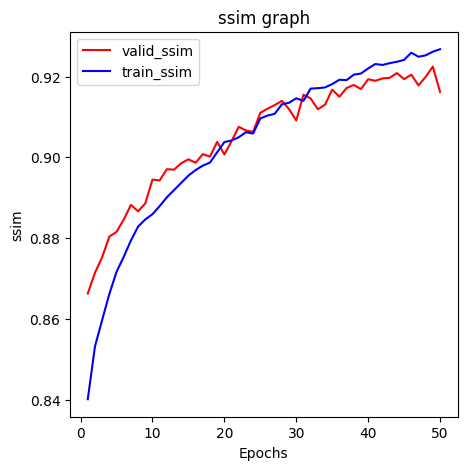

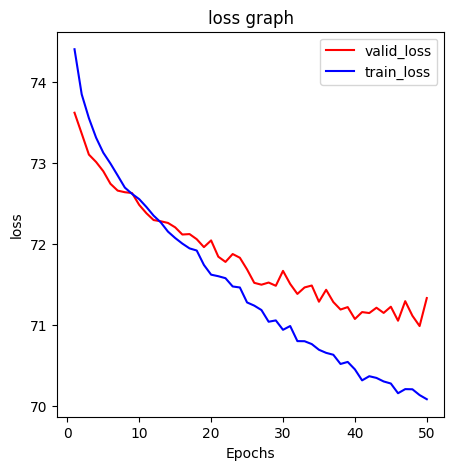

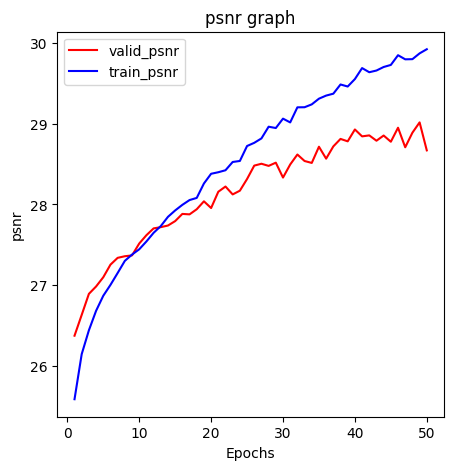

In [15]:
history = trainer.history

epochs = range(1, len(history['train_loss']) + 1)

mode_type = []
plot_type = []

for k, v in history.items():
    metric_type = k.split('_')
    mode_type.append(metric_type[0])
    plot_type.append(metric_type[-1])

mode_type = list(set(mode_type))
plot_type = list(set(plot_type))

for type in plot_type :
    train_str = str(mode_type[0])+'_'+str(type)
    valid_str = str(mode_type[1])+'_'+str(type)
    
    plt.figure(figsize=(5, 5))
    plt.plot(epochs, history[train_str], 'r', label=f'{train_str}')
    plt.plot(epochs, history[valid_str], 'b', label=f'{valid_str}')
    plt.title(f'{type} graph')
    plt.xlabel('Epochs')
    plt.ylabel(f'{type}')
    plt.legend()
    plt.show()

## Test Result Checking

In [ ]:
##### Set model to evaluation mode
from torch.autograd import Variable
model.eval()
cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
# Iterate over a few batches from the test dataset

for batch_idx, (lr,hr) in enumerate(test_dataloader):
    # Get inputs
    imgs_lr = Variable(lr.type(Tensor))
    imgs_hr = Variable(hr.type(Tensor))

    # Forward pass: Generate high-resolution images
    with torch.no_grad():
        gen_hr = model(imgs_lr)

    # Visualize a few sample images
    num_samples = min(100, len(imgs_lr))

    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 10))
    for i in range(num_samples):
        # Original LR image
        axes[i, 0].imshow(imgs_lr[i].cpu().permute(1, 2, 0).numpy())
        axes[i, 0].set_title("Noise")
        axes[i, 0].axis("off")

        # Ground truth HR image
        axes[i, 1].imshow(imgs_hr[i].cpu().permute(1, 2, 0).numpy())
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis("off")

        # Generated HR image
        axes[i, 2].imshow(gen_hr[i].cpu().permute(1, 2, 0).numpy())
        axes[i, 2].set_title("Generated")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

    # Only visualize a few batches
    if batch_idx == 1:
        break
